[Тут](https://github.com/ovbystrova/dpl/blob/master/DataGener_Class.ipynb) версия с генерацией данных. 

In [0]:
!pip install tokenizers
!pip install eli5
#!pip install transformers

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import json
from tqdm import tqdm_notebook
from gensim.models import Word2Vec, KeyedVectors

import torch
from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.vocab import Vectors

from tokenizers import SentencePieceBPETokenizer


LENGTH = 10000
SEED = 42
np.random.seed(SEED)

import nltk
from nltk import tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
def open_file(file):
    with open(file, 'r', encoding='utf-8') as f:
        text_list = [line for line in f.readlines()]
    return text_list

In [0]:
#Запускать если нужен готовый датафрейм (final_df) и файл dataset.csv, без генерации чего либо, сразу модель запускать
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

idd = '1goRkFXGEyrBoDuxfnDvmpHL3QQNM4AWK'
downloaded_ = drive.CreateFile({'id':idd}) 
downloaded_.GetContentFile('dataset.csv')

downloaded_ = drive.CreateFile({'id':'1HmV7mhKV7bS3TsEEgAe60oMoh8pvS7IS'}) 
downloaded_.GetContentFile('fake.txt')

downloaded_ = drive.CreateFile({'id':'1vRBk1xOkRumOavk1RZdTIFI_SebrLCBW'}) 
downloaded_.GetContentFile('real.txt')

fake = open_file('fake.txt')
real = open_file('real.txt')

final_df = pd.read_csv('dataset.csv')

In [0]:
assert len(fake) == len(real)

In [0]:
fake[:5], real[:5]

(['Spinach has terrorized generations of veggie-phobic kids, and many grownups don\'t much like it, either.."I think it\'s a little bit of a shock to see that he\'s been able to do this,"\n',
  'All day, every day, Cheryl Bernstein thanks her 16-month-old son. the boy is a little boy.\n',
  'With Police Commissioner Bernard Kerik cracking the whip, the NYPD is suddenly responding to crime faster than it has in several years. the NYPD is now responding to crime faster than it has in several years.\n',
  "Wednesday, April 19th 1995, 2:35AM Jail inmates flout the city's newest law every day, with no fear of punishment., with no fear of punishment.\n",
  "BY GEORGE RUSH AND JOANNA MOLLOY With Kasia Anderson and Suzanne Rozdeba Thursday, August 8th 2002, 7:06AM Did Tatum O'Neal's latest battle with ex-husband John McEnroe put her back on drugs?, or was it just a matter of time before she was caught?\n"],
 ["Spinach has terrorized generations of veggie-phobic kids, and many grownups don't mu

# Sentencepiece and train embeddings - 0.98 on test????

In [0]:
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip 'wikitext-2-v1.zip'

--2020-02-14 13:14:46--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.104.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.104.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘wikitext-2-v1.zip’

wikitext-2-v1.zip   100%[===================>]   4.27M  2.45MB/s    in 1.7s    

2020-02-14 13:14:48 (2.45 MB/s) - ‘wikitext-2-v1.zip’ saved [4475746/4475746]

Archive:  wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


In [0]:
tokenizer = SentencePieceBPETokenizer()
tokenizer.train(['/content/wikitext-2/wiki.test.tokens', '/content/wikitext-2/wiki.train.tokens', '/content/wikitext-2/wiki.valid.tokens'], special_tokens=['<eos>', '<unk>', '<start>'], vocab_size=30000)
tokenizer

Tokenizer(vocabulary_size=30001, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [0]:
def tokenize(text, tokenizer=tokenizer):
    return tokenizer.encode(text).tokens

In [0]:
print(tokenize(fake[0]))
print(tokenize(real[0]))

['▁Spin', 'ach', '▁has', '▁terror', 'ized', '▁generations', '▁of', '▁ve', 'gg', 'ie', '-', 'ph', 'obic', '▁kids', ',', '▁and', '▁many', '▁grown', 'up', 's', '▁don', "'", 't', '▁much', '▁like', '▁it', ',', '▁either', '..', '"', 'I', '▁think', '▁it', "'", 's', '▁a', '▁little', '▁bit', '▁of', '▁a', '▁shock', '▁to', '▁see', '▁that', '▁he', "'", 's', '▁been', '▁able', '▁to', '▁do', '▁this', ',', '"', '▁']
['▁Spin', 'ach', '▁has', '▁terror', 'ized', '▁generations', '▁of', '▁ve', 'gg', 'ie', '-', 'ph', 'obic', '▁kids', ',', '▁and', '▁many', '▁grown', 'up', 's', '▁don', "'", 't', '▁much', '▁like', '▁it', ',', '▁either', '.', '▁But', '▁when', '▁it', "'", 's', '▁combined', '▁with', '▁season', 'ings', '▁and', '▁fet', 'a', '▁cheese', '▁and', '▁wrapped', '▁in', '▁a', '▁golden', '▁cr', 'isp', '▁p', 'hy', 'llo', '▁d', 'ough', '▁crust', ',', '▁even', '▁those', '▁who', '▁desp', 'ise', '▁Pope', 'y', 'e', "'", 's', '▁favorite', '▁food', '▁ask', '▁for', '▁seconds', '.', '▁']


## Разного размера датасеты чтобы были

In [0]:
len(fake), len(real)

(37366, 37366)

Возьмем 10к, 20к, 30к, 37к.

In [0]:
def create_csv_file(fake, real, length):
    fake_list = list(zip(fake[:length],['fake']*length))
    real_list = list(zip(real[:length],['real']*length))

    final_list = fake_list + real_list    
    df = pd.DataFrame(final_list, columns=['text','label'])
    df.to_csv("dataset{}.csv".format(length), index=False)    
    return df

In [0]:
lengths = [10000, 20000, 30000, 37666]
for length in lengths:
    create_csv_file(fake, real, length)

In [0]:
MAX_VOCAB_SIZE = 50000
classes={'fake': 0, 'real': 1}


TEXT = Field(sequential=True, include_lengths=False, batch_first=True, tokenize=tokenize, 
             pad_first=True, lower=True, eos_token='<eos>') 
LABEL = LabelField(dtype=torch.float, use_vocab=True, preprocessing=lambda x: classes[x])


global_history = pd.DataFrame()
for length in lengths:
    dataset = TabularDataset('dataset{}.csv'.format(length), 
                                    format='csv', fields=[('text', TEXT), ('label',LABEL),], 
                                    skip_header=True)
    TEXT.build_vocab(dataset,  max_size=MAX_VOCAB_SIZE, min_freq=2)
    LABEL.build_vocab(dataset)
    vocab = TEXT.vocab
    print('Vocab size for dataset of length {} samples:'.format(length), len(TEXT.vocab.itos))
    TEXT.vocab.itos[:10]

    train, test = dataset.split(0.8, stratified=True)
    train, valid = train.split(0.8, stratified=True)

    batch_size = 256

    model = MyModel(len(TEXT.vocab.itos),
                    embed_size=100,
                    hidden_size=128,
                )

    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train, valid, test),
        batch_sizes=(batch_size, batch_size, batch_size),
        shuffle=True,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
    )

    optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, cooldown=5)
    criterion = nn.BCEWithLogitsLoss()

    history = nn_train(model, train_iterator, valid_iterator,
          criterion, optimizer, n_epochs=5, early_stopping=2)
    
    test_accuracy = test_model(model, test_iterator)
    global_history = global_history.append(history, ignore_index=True)
    print('Test accuracy for dataset of length {} samples: {}'.format(length, np.mean(test_accuracy)))

Vocab size for dataset of length 10000 samples: 16514



validation loss 0.50795 validation accuracy  0.75240



validation loss 0.41579 validation accuracy  0.78320



validation loss 0.25014 validation accuracy  0.82362



validation loss 0.12546 validation accuracy  0.85750



validation loss 0.09921 validation accuracy  0.87927
Test accuracy for dataset of length 10000 samples: 0.957470715045929
Vocab size for dataset of length 20000 samples: 18934



validation loss 0.38850 validation accuracy  0.83125



validation loss 0.14527 validation accuracy  0.88953



validation loss 0.09083 validation accuracy  0.91589



validation loss 0.07390 validation accuracy  0.93055



validation loss 0.08014 validation accuracy  0.93859
Test accuracy for dataset of length 20000 samples: 0.97021484375
Vocab size for dataset of length 30000 samples: 20091



validation loss 0.28610 validation accuracy  0.88518



validation loss 0.09505 validation accuracy  0.92630



validation loss 0.06792 validation accuracy  0.94298



validation loss 0.06165 validation accuracy  0.95205



validation loss 0.05749 validation accuracy  0.95796
Test accuracy for dataset of length 30000 samples: 0.9816797971725464
Vocab size for dataset of length 37666 samples: 20656



validation loss 0.14684 validation accuracy  0.94936



validation loss 0.06972 validation accuracy  0.96275



validation loss 0.06684 validation accuracy  0.96735



validation loss 0.05808 validation accuracy  0.97059



validation loss 0.05257 validation accuracy  0.97304
Test accuracy for dataset of length 37666 samples: 0.9821752905845642


In [0]:
global_history

,epoch,train_acc,train_loss,valid_acc,valid_loss
0,0.0,0.638359,0.480112,0.752404,0.507953
1,1.0,0.690898,0.381493,0.783203,0.415793
2,2.0,0.749167,0.345071,0.823618,0.250139
3,3.0,0.796113,0.171527,0.857497,0.125464
4,4.0,0.830437,0.054028,0.879267,0.099205
5,0.0,0.688594,0.377223,0.831250,0.388503
6,1.0,0.789922,0.092355,0.889531,0.145268
7,2.0,0.847852,0.092349,0.915885,0.090826
8,3.0,0.880186,0.093986,0.930547,0.073898
9,4.0,0.900852,0.036759,0.938594,0.080144


In [0]:
# Тестовая accuracy в зависимости от размера датасета.
# 0.957470715045929
# 0.97021484375
# 0.9816797971725464
# 0.9821752905845642

In [0]:
# Первые пять - 10к
# Вторые пять - 20к
# Третьи пять - 30к
# Четвертые пять - 37к
global_history.to_csv('global_history.csv', index=False)

In [0]:
history['valid_loss']

0    0.146844
1    0.069720
2    0.066843
3    0.058079
4    0.052565
Name: valid_loss, dtype: float64

In [0]:
history['valid_loss'][5:10]

Series([], Name: valid_loss, dtype: float64)

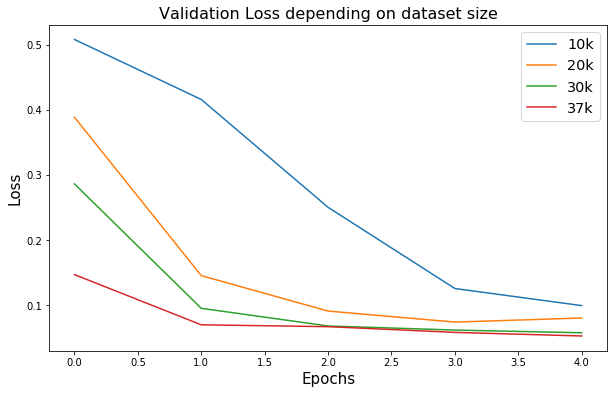

In [0]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(5), global_history['valid_loss'][:5], label='10k')
plt.plot(np.arange(5), global_history['valid_loss'][5:10], label='20k')
plt.plot(np.arange(5), global_history['valid_loss'][10:15], label='30k')
plt.plot(np.arange(5), global_history['valid_loss'][15:], label='37k')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Validation Loss depending on dataset size', size=16)
plt.legend(fontsize='x-large')
plt.show()

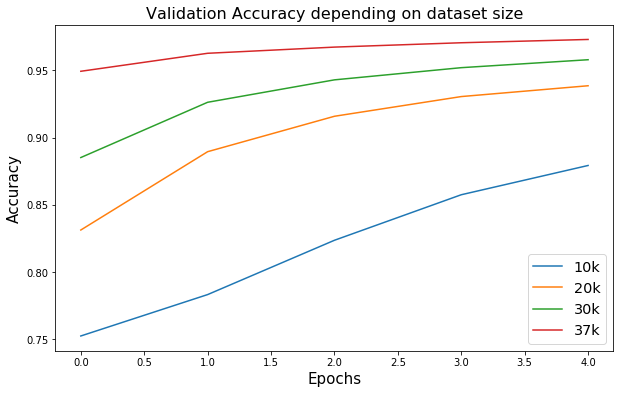

In [0]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(5), global_history['valid_acc'][:5], label='10k')
plt.plot(np.arange(5), global_history['valid_acc'][5:10], label='20k')
plt.plot(np.arange(5), global_history['valid_acc'][10:15], label='30k')
plt.plot(np.arange(5), global_history['valid_acc'][15:], label='37k')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Validation Accuracy depending on dataset size', size=16)
plt.legend(fontsize='x-large')
plt.show()

## Сюда если пофиг на размер и берем все

In [0]:
MAX_VOCAB_SIZE = 50000
classes={'fake': 0, 'real': 1}


TEXT = Field(sequential=True, include_lengths=False, batch_first=True, tokenize=tokenize, 
             pad_first=True, lower=True, eos_token='<eos>') 
LABEL = LabelField(dtype=torch.float, use_vocab=True, preprocessing=lambda x: classes[x])


dataset = TabularDataset('dataset.csv', 
                                format='csv', fields=[('text', TEXT), ('label',LABEL),], 
                                skip_header=True)

TEXT.build_vocab(dataset,  max_size=MAX_VOCAB_SIZE, min_freq=2)
LABEL.build_vocab(dataset)
vocab = TEXT.vocab
print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

Vocab size: 20656


['<unk>', '<pad>', '<eos>', '▁the', ',', '.', '▁a', '▁of', '▁to', '▁in']

In [0]:
train, test = dataset.split(0.8, stratified=True)
train, valid = train.split(0.8, stratified=True)

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2 *2, 1)
    def forward(self, x):
        
        x = self.embedding(x)
           
        _, (hidden, cell) = self.rnn(x)
        
        hidden = hidden.transpose(0,1)
        cell = cell.transpose(0,1)
        hidden = hidden.contiguous().view(hidden.size(0),-1)
        cell = cell.contiguous().view(cell.size(0),-1)
        x = torch.cat([hidden, cell], dim=1).squeeze(1)
        x = self.fc(x)
        return x

In [0]:
batch_size = 256

model = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
)

optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, cooldown=5)
criterion = nn.BCEWithLogitsLoss()

In [0]:
b = next(iter(train_iterator)); vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])

In [0]:
def accuracy_score(preds, y):
    preds = torch.round(torch.sigmoid(preds))
    preds = (preds == y).float()
    accuracy = preds.sum() / len(preds)
    return accuracy

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):
    model.train()

    running_loss = 0
    losses = []
    train_acc = []

    n_batches = len(iterator)
    
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)
    
    for i, batch in enumerate(iterator):
        x = batch.text
        y = batch.label
        optimizer.zero_grad()
        preds = model(x).squeeze(1)
        loss = criterion(preds, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        
        curr_loss = loss.data.detach().item()
        losses.append(loss.item())

        acc = accuracy_score(preds, y)
        train_acc.append(acc)

        iterator.set_postfix(loss='%.5f' % curr_loss, acc='%.5f' % acc)

    return curr_loss, losses, train_acc

def _test_epoch(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    losses = []
    test_acc = []

    n_batches = len(iterator)

    with torch.no_grad():
        for batch in iterator:
            x = batch.text
            y = batch.label
            preds = model(x).squeeze(1)
            test_acc.append(accuracy_score(preds, y))

            loss = criterion(preds, y)
            losses.append(loss.item())
            epoch_loss += loss.data.item()
    return epoch_loss / n_batches, losses, test_acc

def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=20, early_stopping=0):

    prev_loss = 10500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(n_epochs):
        train_loss, epoch_tl, train_acc = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss,  epoch_vl, valid_acc = _test_epoch(model, valid_iterator, criterion)

        train_losses.extend(epoch_tl)
        valid_losses.extend(epoch_vl)
        train_accs.extend(train_acc)
        valid_accs.extend(valid_acc)

        print('validation loss %.5f' % valid_loss, 'validation accuracy  %.5f' % np.mean(valid_accs))

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss, 'train_acc': np.mean(train_accs), 'valid_acc':np.mean(valid_accs)}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history

In [0]:
def test_model(model, test_iterator):
    test_acc = []

    with torch.no_grad():
        for item in test_iterator:
            x = item.text
            y = item.label
            preds = model(x).squeeze(1)
            test_acc.append(accuracy_score(preds, y))
    test_acc = np.mean(test_acc) 
    return np.mean(test_acc)

In [0]:
history = nn_train(model, train_iterator, valid_iterator,
          criterion, optimizer, n_epochs=5, early_stopping=2)


validation loss 0.14629 validation accuracy  0.94553



validation loss 0.06981 validation accuracy  0.96117



validation loss 0.05449 validation accuracy  0.96791



validation loss 0.05044 validation accuracy  0.97181



validation loss 0.04505 validation accuracy  0.97438


In [0]:
test_accuracy = test_model(model, test_iterator)
print('Test accuracy: {}'.format(np.mean(test_accuracy)))

Test accuracy: 0.9826536178588867


In [0]:
history

,epoch,train_acc,train_loss,valid_acc,valid_loss
0,0.0,0.765845,0.084332,0.945528,0.146287
1,1.0,0.866815,0.042919,0.961170,0.069805
2,2.0,0.905029,0.037741,0.967908,0.054490
3,3.0,0.925694,0.041283,0.971808,0.050438
4,4.0,0.938793,0.050246,0.974381,0.045050


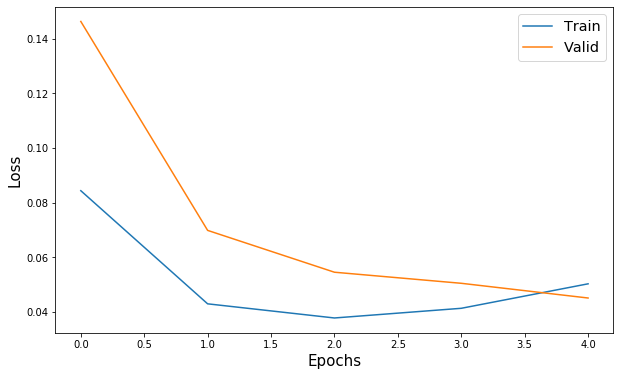

In [0]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['valid_loss'])), history['valid_loss'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

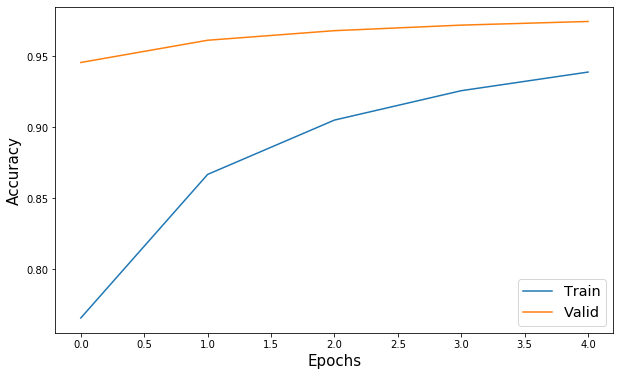

In [0]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_acc'])), history['train_acc'], label='Train')
plt.plot(np.arange(len(history['valid_acc'])), history['valid_acc'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

# MORE ELI5

In [0]:
# https://github.com/ArmandDS/toxic_detection/blob/master/toxic_detection.ipynb

# TODO Ну ебана пусть оно заработает уже

In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
import eli5

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
a = next(iter(test_iterator)); vars(b).keys()
a.text.size()

NameError: ignored

In [0]:
text = 'And if you go i wanna go with you and if you die i wanna die with you take your hand and walk away'
tokenized = tokenize(text)
print(tokenized)

ids = [vocab.stoi[el] for el in tokenized]
print(ids)

tensor = torch.tensor(ids)
tensor = tensor.unsqueeze(0)
print(tensor.size(), tensor)

logit = model.forward(tensor)
print(logit)

print(torch.round(torch.sigmoid(logit)))

['▁And', '▁if', '▁you', '▁go', '▁i', '▁wanna', '▁go', '▁with', '▁you', '▁and', '▁if', '▁you', '▁die', '▁i', '▁wanna', '▁die', '▁with', '▁you', '▁take', '▁your', '▁hand', '▁and', '▁walk', '▁away']
[0, 129, 44, 184, 48, 13642, 184, 24, 44, 10, 129, 44, 2992, 48, 13642, 2992, 24, 44, 289, 141, 882, 10, 1789, 582]
torch.Size([1, 24]) tensor([[    0,   129,    44,   184,    48, 13642,   184,    24,    44,    10,
           129,    44,  2992,    48, 13642,  2992,    24,    44,   289,   141,
           882,    10,  1789,   582]])
tensor([[-0.1405]], grad_fn=<AddmmBackward>)
tensor([[0.]], grad_fn=<RoundBackward>)


In [0]:
a = torch.rand(2,1)
print(a, a.size())

b = 1 - a
print(b, b.size())

c = torch.cat((a,b), dim=-1)
print(c, c.size())

tensor([[0.8107],
        [0.6112]]) torch.Size([2, 1])
tensor([[0.1893],
        [0.3888]]) torch.Size([2, 1])
tensor([[0.8107, 0.1893],
        [0.6112, 0.3888]]) torch.Size([2, 2])


In [0]:
class LSTMClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, model, optimizer, scheduler, criterion):
        super(LSTMClassifier, self).__init__() 
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.classes_ = (0,1)

    def fit(self, X=None, y=None, **kwargs): # Что-то я сделала и почему-то оно вообще заработало
        nn_train(self.model, train_iterator, valid_iterator, self.criterion, self.optimizer, n_epochs=5, early_stopping=2)

        return self

    def predict_proba(self, texts):
        """
        texts: list of texts
        :return: ndarray n_texts x n_classes
        """

        tokenized_texts = [tokenize(text) for text in texts]
    
        ids = [[vocab.stoi[token] for token in text] for text in tokenized_texts]
        
        for ind, el in enumerate(ids): # Чтобы до одинаковой длинны
            if len(el) < len(tokenized_texts[0]):
                while len(el) < len(tokenized_texts[0]):
                    el.append(1)
            if len(el) > len(tokenized_texts[0]):
                ids[ind] = el[:len(tokenized_texts[0])]            
        
        tensor = torch.tensor(ids)
        self.model.eval()
        with torch.no_grad():
            logits = self.model.forward(tensor)
        sigmoids = torch.sigmoid(logits)
        opposite_class_prob = 1 - sigmoids
        probs = torch.cat((sigmoids, opposite_class_prob), dim=-1)
        
        return probs.detach().numpy()

    def predict(self, text):
        return int(torch.round(self.predict_proba(text)).item())

In [0]:
model_estimator = LSTMClassifier(model, optimizer, scheduler, criterion)

In [0]:
model_estimator.fit()

KeyboardInterrupt: ignored

In [0]:
model_estimator.predict_proba([text])

array([[0.46493307, 0.53506696]], dtype=float32)

In [0]:
model_estimator.model.classes

(0, 1)

In [0]:
help(TextExplainer.fit)

In [0]:
print(tokenize(text))
print([vocab.stoi[el] for el in tokenize(text)])

['▁What', '▁is', '▁love', '▁ladies', '▁d', 'ont', '▁hurt', '▁me', '▁ladies', '▁d', 'ont', '▁hurt', '▁me', '▁no', '▁more']
[0, 14, 650, 6017, 120, 4130, 3613, 326, 6017, 120, 4130, 3613, 326, 181, 66]


In [0]:
from eli5.lime import TextExplainer

# te = TextExplainer(clf=model_estimator, random_state=42)
te = TextExplainer(random_state=42)
te.fit(doc=text, predict_proba=model_estimator.predict_proba)
te.show_prediction(target_names=['Fake','Real'])

In [0]:
text

'And if you go i wanna go with you and if you die i wanna die with you take your hand and walk away'

In [0]:
help(eli5.explain_prediction)

In [0]:
help(te.show_prediction)

In [0]:
import sklearn
print(sklearn.__version__)

0.22.1


In [0]:
def decode(numbers):
    return [vocab.itos[ind] for ind in numbers]

decode([14, 335, 6017, 120, 4130, 3613, 326, 6017, 120, 4130, 335, 326, 181, 66])

['▁is',
 '▁',
 '▁ladies',
 '▁d',
 'ont',
 '▁hurt',
 '▁me',
 '▁ladies',
 '▁d',
 'ont',
 '▁',
 '▁me',
 '▁no',
 '▁more']

# Scorch 

In [0]:
!pip install -U skorch

     |████████████████████████████████| 112kB 9.7MB/s 


In [0]:
from skorch import NeuralNetClassifier

In [0]:
net = NeuralNetClassifier(
    model,
    max_epochs=20,
    lr=0.001
)

In [0]:
for el in train_iterator:
    net.fit(el.text, el.label.long())

IndexError: ignored

In [0]:
print(text)
tokenized_text = tokenize(text)
ids = [vocab.stoi[token] for token in tokenized_text]  
tensor = torch.tensor(ids).unsqueeze(0)
print(tensor.size())

What is love ladies dont hurt me ladies dont hurt me no more
torch.Size([1, 15])


In [0]:
net.predict(tensor)

array([0])

In [0]:
net.predict_proba(tensor)

array([[0.53172815]], dtype=float32)

In [0]:
from eli5.lime import TextExplainer

te = TextExplainer(clf=net, random_state=42)
te.fit(doc=text, predict_proba=net.predict_proba)
te.show_prediction(target_names=['Fake','Real'])

ValueError: ignored

In [0]:
eli5.explain_weights(net)

Explanation(estimator="<class 'skorch.classifier.NeuralNetClassifier'>[initialized](\n  module_=MyModel(\n    (embedding): Embedding(20656, 100)\n    (rnn): LSTM(100, 128, batch_first=True, bidirectional=True)\n    (fc): Linear(in_features=512, out_features=1, bias=True)\n  ),\n)", description=None, error="estimator <class 'skorch.classifier.NeuralNetClassifier'>[initialized](\n  module_=MyModel(\n    (embedding): Embedding(20656, 100)\n    (rnn): LSTM(100, 128, batch_first=True, bidirectional=True)\n    (fc): Linear(in_features=512, out_features=1, bias=True)\n  ),\n) is not supported", method=None, is_regression=False, targets=None, feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)